In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

data = Path("../data")
plot_path = Path("plots")

# Load users dataset

302,673 unique users, 55,280 unique location strings

In [2]:
users = pd.read_csv(data / "UserList.csv")
print("Number of unique users: {:,}".format(users["user_id"].nunique()))
print("Number of unique locations: {:,}".format(users["location"].nunique()))
users

Number of unique users: 302,673
Number of unique locations: 55,280


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,shuzzable,2347781,36,72,16,2,25,35.48,NaN,NaN,NaN,NaN,2013-03-25,2015-09-09 21:54:00,9.06,7.0,2154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302670,ScruffyPuffy,3119025,0,27,0,0,0,7.92,NaN,NaN,NaN,NaN,2013-09-06,2014-10-10 09:04:00,0.00,0.0,477.0
302671,Torasori,3975907,22,239,0,4,176,86.88,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0
302672,onpc,1268417,5,169,2,5,24,38.36,Male,NaN,NaN,NaN,2012-04-23,2016-12-28 14:35:00,7.72,0.0,2280.0
302673,HMicca,1289601,11,73,2,2,16,119.97,Female,"Birmingham, England",1995-08-12,NaN,2012-05-05,2012-11-15 08:10:00,8.89,11.0,7049.0


In [3]:
# Keep users with non-null location
users = users[users["location"].notnull()]

# strip all locations
users.loc[:, "location"] = users.loc[:, "location"].str.strip()

print("Number of unique users: {:,}".format(users["user_id"].nunique()))
print("Number of unique locations: {:,}".format(users["location"].nunique()))

Number of unique users: 156,774
Number of unique locations: 53,762


/tmp/ipykernel_16015/1065557805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.loc[:, "location"] = users.loc[:, "location"].str.strip()


# Map location strings to country names

In [4]:
from functools import partial
from geopy.geocoders import Nominatim
from deep_translator import GoogleTranslator

import country_converter as coco

coco.logging.getLogger().setLevel(coco.logging.ERROR)

translator = GoogleTranslator(source="auto", target="en")
geolocator = Nominatim(user_agent="GoogleV3")
geocode = partial(geolocator.geocode, language="en")


def findCountry(location):
    if location.isdigit():
        print(location, "(is digit)")
        return ""

    try:
        result = geocode(location, timeout=5)
    except:
        print(location, "(geocode)")
        return ""
    if result is not None:
        country = result.address.split(",")[-1].strip()
        return country

    country = coco.convert(names=location, to="name_short")
    if country != "not found":
        return country

    translated = translator.translate(location)
    if translated is None:
        print(location, "(translation not found)")
        return ""
    if translated == location:
        print(location, "(not found)")
        return ""

    try:
        result = geocode(translated, timeout=5)
    except:
        print(location, "->", translated, "(geocode)")
        return ""
    if result is not None:
        country = result.address.split(",")[-1].strip()
        return country

    country = coco.convert(names=translated, to="name_short")
    if country != "not found":
        return country
    print(location, "->", translated, "(not found)")
    return ""

# Cleaning countries

- Fix the incorrect mappings
- Add a "ambiguous" class for locations that are not precise enough and that may correspond to cities of the same name but in different countries
- For lists of countries, ...

In [5]:
df_ltc_clean = pd.read_csv(data / "location_to_country_clean.csv")

# For all the lines whose first column contains "Puerto Rico", replace the country with "Puerto Rico"
# df_ltc_clean.loc[df_ltc_clean["location"].str.contains("Puerto Rico"), "country"] = "Puerto Rico"

df_ltc_clean.sort_values(["country", "location"], ascending=[True, True]).to_csv(
    data / "location_to_country_clean.csv", index=False
)

In [6]:
unique_countries = df_ltc_clean["country"].sort_values().unique()
print("Number of unique countries:", len(unique_countries))
print(*unique_countries, sep="\n")

Number of unique countries: 317
Afghanistan
Albania
Algeria
Andorra
Angola
Anguilla
Antarctica
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Bermuda
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Cabo Verde
Cambodia
Cameroon
Canada
Canarias
Cayman Islands
Chad
Chile
China
Christmas Island
Colombia
Congo
Congo DRC
Costa Rica
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Côte d'Ivoire
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Eswatini
Faroe Islands
Fiji
Finland
France
French Guiana
French Polynesia
Gabon
Georgia
Germany
Ghana
Greece
Greenland
Grenada
Guam
Guatemala
Guernsey
Guinea
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kiribati
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Leba

# Countries centroids dataset ([country_centroids.csv](country_centroids.csv))

- Fix country names of the mappings to match the "COUNTRY" columns
- Add missing country-centroids pairs: Taiwan, Kosovo, Null Island

In [7]:
centroids = pd.read_csv(data / "country_centroids.csv")
centroids

,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
0,-170.700732,-14.305712,American Samoa,AS,United States,US
1,166.638003,19.302046,United States Minor Outlying Islands,UM,United States,US
2,-159.787689,-21.222613,Cook Islands,CK,New Zealand,NZ
3,-149.400417,-17.674684,French Polynesia,PF,France,FR
4,-169.868781,-19.052309,Niue,NU,New Zealand,NZ
...,...,...,...,...,...,...
247,-3.651625,40.365008,Spain,ES,Spain,ES
248,-16.537994,28.297665,Canarias,ES,Spain,ES
249,23.700000,121.000000,Taiwan,TW,Taiwan,TW
250,42.600000,20.900000,Kosovo,XK,Kosovo,XK


Some countries have affiliated territories, such as the United Kingdom, France, Spain, Netherlands, etc. We will consider these territories as part of the country they are affiliated to.

In [8]:
centroids[centroids["COUNTRYAFF"] == "France"]

,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
3,-149.400417,-17.674684,French Polynesia,PF,France,FR
9,-178.127356,-14.283442,Wallis and Futuna,WF,France,FR
43,-53.322323,3.857430,French Guiana,GF,France,FR
45,-61.543823,16.244200,Guadeloupe,GP,France,FR
50,-61.014324,14.642697,Martinique,MQ,France,FR
56,-62.830516,17.905617,Saint Barthelemy,BL,France,FR
60,-63.066785,18.078012,Saint Martin,MF,France,FR
61,-56.324654,46.951539,Saint Pierre and Miquelon,PM,France,FR
105,42.743748,-17.064492,Juan De Nova Island,TF,France,FR
116,69.546870,-49.263297,French Southern Territories,TF,France,FR


In [9]:
centroids[centroids["COUNTRYAFF"] == "United States"]

,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
0,-170.700732,-14.305712,American Samoa,AS,United States,US
1,166.638003,19.302046,United States Minor Outlying Islands,UM,United States,US
54,-66.494253,18.216224,Puerto Rico,PR,United States,US
67,-64.761553,17.738010,US Virgin Islands,VI,United States,US
154,-96.331617,38.820809,United States,US,United States,US
240,144.780245,13.445430,Guam,GU,United States,US
244,145.741197,15.178064,Northern Mariana Islands,MP,United States,US


In [10]:
countries_centroids = centroids["COUNTRY"].sort_values().unique()
print(*countries_centroids, sep="\n")

Afghanistan
Albania
Algeria
American Samoa
Andorra
Angola
Anguilla
Antarctica
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bonaire
Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Canarias
Cayman Islands
Central African Republic
Chad
Chile
China
Christmas Island
Cocos Islands
Colombia
Comoros
Congo
Congo DRC
Cook Islands
Costa Rica
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Côte d'Ivoire
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Falkland Islands
Faroe Islands
Fiji
Finland
France
French Guiana
French Polynesia
French Southern Territories
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Glorioso Islands
Greece
Greenland
Grenada
Guadeloupe
Guam
Guatemala
Guern

# Merge

In [11]:
df_ltc_clean = pd.read_csv(data / "location_to_country_clean.csv")

# whenever there is "Russia" in the second column, rename it to "Russian Federation"
# df_location_to_country_sorted.loc[df_location_to_country_sorted["country"] == "Russia", "country"] = "Russian Federation"

df_ltc_clean.sort_values(["country", "location"], ascending=[True, True]).to_csv(
    data / "location_to_country_clean.csv", index=False
)

## Merge with users dataset

In [12]:
# transform as a dictionary
dict_ltc = df_ltc_clean.set_index("location")["country"].to_dict()
users.loc[:, "country"] = users.loc[:, "location"].map(dict_ltc)
users

/tmp/ipykernel_16015/1750862515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.loc[:, "country"] = users.loc[:, "location"].map(dict_ltc)


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,Philippines
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
5,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302658,Queenjdlols,3495411,4,123,6,4,49,22.55,Female,Head in the clouds body on the ground,NaN,NaN,2014-01-16,1900-04-29 00:19:00,6.77,3.0,1375.0,NaN
302662,TheClockworkGuy,4273353,5,77,8,12,61,48.03,Male,Yharnam,NaN,NaN,2014-11-23,1900-05-22 02:49:00,6.85,0.0,2826.0,United States
302668,ichinitan,4531649,3,24,5,0,246,8.72,NaN,"Alexandria, Virginia",2000-05-12,NaN,2015-04-01,2017-10-12 14:22:00,9.46,0.0,528.0,United States
302671,Torasori,3975907,22,239,0,4,176,86.88,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia


## Cleaning users
- Remove the users who have undefined countries

In [13]:
num_unique_users = users["user_id"].nunique()

# Users whose country is undefined (country is "" or is null)
num_undefined = users[users["country"].isnull() | (users["country"] == "")][
    "user_id"
].nunique()
print(
    "Number of users whose country is undefined: {:,} ({:.2f}%)".format(
        num_undefined, 100 * num_undefined / num_unique_users
    )
)
users = users[users["country"].notnull() & (users["country"] != "")]

print(
    "Number of users whose country is defined: {:,}".format(users["user_id"].nunique())
)

Number of users whose country is undefined: 20,499 (13.08%)
Number of users whose country is defined: 136,275


TODO with the list of countries

In [14]:
users[users["country"].str.contains(",")]

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
3218,iTenshiiii,4196515,2,641,0,0,338,202.70,Male,"Finland, Sweden",NaN,NaN,2014-10-22,2017-10-14 03:11:00,5.70,7.0,13446.0,"['Finland', 'Sweden']"
4518,SarahFukui,208595,8,98,0,1,8,29.91,Female,"Singapore, Bosnia and Herzegovina",NaN,NaN,2009-07-16,2017-12-18 10:16:00,8.07,0.0,1778.0,"['Bosnia and Herzegovina', 'Singapore']"
5103,inaa,444381,6,45,0,3,106,15.01,Female,Holland/Poland,1995-11-22,NaN,2011-02-04,2017-05-09 03:20:00,8.10,0.0,895.0,"['Netherlands', 'Poland']"
6278,TokyoNeonLight,160356,20,202,22,3,48,34.82,Male,"Podgorica, Montenegro / Toronto, Ontario, Canada",1986-11-08,NaN,2009-03-18,2015-04-10 22:55:00,7.76,8.0,2042.0,"['Canada', 'Montenegro']"
7188,Arex,465255,1,293,24,4,98,93.62,Male,Taiwan & South Africa,NaN,NaN,2011-03-24,1900-04-29 06:20:00,7.50,0.0,5564.0,"['South Africa', 'Taiwan']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278512,Zhie1,3060195,15,348,29,59,3,246.46,Male,"Indonesia, Egypt",NaN,NaN,2013-08-17,2015-12-27 03:29:00,6.65,5.0,16616.0,"['Egypt', 'Indonesia']"
285310,NaturalPerm,2117521,25,1123,7,87,68,319.51,Male,somewhere in Austria/Germany,1994-01-01,NaN,2013-01-31,2018-05-24 21:04:39,6.15,47.0,18791.0,"['Austria', 'Germany']"
286854,AdamNyandere,4539831,11,43,7,1,25,47.37,Male,Singapore / Malaysia,1984-11-18,NaN,2015-04-05,2018-05-23 07:28:00,9.07,60.0,3967.0,"['Malaysia', 'Singapore']"
289896,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",1991-09-11,NaN,2009-10-05,2012-09-27 12:01:00,8.63,0.0,2521.0,"['Germany', 'Greece']"


In [15]:
# for all the users who have a "country" column of the form "['', '']", remove the [] and ''. For instance, "['Finland', 'Sweden']" becomes "Finland, Sweden"
users.loc[:, "country"] = (
    users.loc[:, "country"]
    .str.replace(r"^\[\'", "")
    .str.replace(r"\'\]$", "")
    .str.replace(r"\'\,\s\'", ", ")
)
users[users["country"].str.contains(",")]

/tmp/ipykernel_16015/1358987298.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"^\[\'", "")
/tmp/ipykernel_16015/1358987298.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\'\]$", "")
/tmp/ipykernel_16015/1358987298.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\'\,\s\'", ", ")
/tmp/ipykernel_16015/1358987298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.loc[:, "country"] = (


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
3218,iTenshiiii,4196515,2,641,0,0,338,202.70,Male,"Finland, Sweden",NaN,NaN,2014-10-22,2017-10-14 03:11:00,5.70,7.0,13446.0,"Finland, Sweden"
4518,SarahFukui,208595,8,98,0,1,8,29.91,Female,"Singapore, Bosnia and Herzegovina",NaN,NaN,2009-07-16,2017-12-18 10:16:00,8.07,0.0,1778.0,"Bosnia and Herzegovina, Singapore"
5103,inaa,444381,6,45,0,3,106,15.01,Female,Holland/Poland,1995-11-22,NaN,2011-02-04,2017-05-09 03:20:00,8.10,0.0,895.0,"Netherlands, Poland"
6278,TokyoNeonLight,160356,20,202,22,3,48,34.82,Male,"Podgorica, Montenegro / Toronto, Ontario, Canada",1986-11-08,NaN,2009-03-18,2015-04-10 22:55:00,7.76,8.0,2042.0,"Canada, Montenegro"
7188,Arex,465255,1,293,24,4,98,93.62,Male,Taiwan & South Africa,NaN,NaN,2011-03-24,1900-04-29 06:20:00,7.50,0.0,5564.0,"South Africa, Taiwan"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278512,Zhie1,3060195,15,348,29,59,3,246.46,Male,"Indonesia, Egypt",NaN,NaN,2013-08-17,2015-12-27 03:29:00,6.65,5.0,16616.0,"Egypt, Indonesia"
285310,NaturalPerm,2117521,25,1123,7,87,68,319.51,Male,somewhere in Austria/Germany,1994-01-01,NaN,2013-01-31,2018-05-24 21:04:39,6.15,47.0,18791.0,"Austria, Germany"
286854,AdamNyandere,4539831,11,43,7,1,25,47.37,Male,Singapore / Malaysia,1984-11-18,NaN,2015-04-05,2018-05-23 07:28:00,9.07,60.0,3967.0,"Malaysia, Singapore"
289896,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",1991-09-11,NaN,2009-10-05,2012-09-27 12:01:00,8.63,0.0,2521.0,"Germany, Greece"


In [16]:
num_unique_users = users["user_id"].nunique()

# for the users who have a "country" column of the form "country1, country2, ..., countryn", duplicate the user n-1 times and assign the country1, country2, ..., countryn to the new users
users_multiple_countries = users[users["country"].str.contains(",")]
users_multiple_countries.loc[:, "country"] = users_multiple_countries.loc[:, "country"].str.split(", ")
users_multiple_countries = users_multiple_countries.explode("country")

# merge the results with the original dataframe
users = pd.concat(
    [users[~users["country"].str.contains(",")], users_multiple_countries], axis=0
)
assert users["user_id"].nunique() == num_unique_users
users

/tmp/ipykernel_16015/2378045049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_multiple_countries.loc[:, "country"] = users_multiple_countries.loc[:, "country"].str.split(", ")


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,Philippines
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
5,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286854,AdamNyandere,4539831,11,43,7,1,25,47.37,Male,Singapore / Malaysia,1984-11-18,NaN,2015-04-05,2018-05-23 07:28:00,9.07,60.0,3967.0,Singapore
289896,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",1991-09-11,NaN,2009-10-05,2012-09-27 12:01:00,8.63,0.0,2521.0,Germany
289896,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",1991-09-11,NaN,2009-10-05,2012-09-27 12:01:00,8.63,0.0,2521.0,Greece
297997,Tachibana-chan,5078714,17,105,2,4,37,24.65,Female,India/Saudi Arabia,2004-01-25,NaN,2015-12-27,1900-05-02 03:48:00,7.32,0.0,1530.0,India


## Merge with centroids dataset

In [17]:
print(*centroids["COUNTRY"].sort_values().unique(), sep="\n")

Afghanistan
Albania
Algeria
American Samoa
Andorra
Angola
Anguilla
Antarctica
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bonaire
Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Canarias
Cayman Islands
Central African Republic
Chad
Chile
China
Christmas Island
Cocos Islands
Colombia
Comoros
Congo
Congo DRC
Cook Islands
Costa Rica
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Côte d'Ivoire
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Falkland Islands
Faroe Islands
Fiji
Finland
France
French Guiana
French Polynesia
French Southern Territories
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Glorioso Islands
Greece
Greenland
Grenada
Guadeloupe
Guam
Guatemala
Guern

In [18]:
# for each user, add a column "COUNTRYAFF" based on "country" column and "COUNTRY" column of centroids
users = users.merge(centroids, left_on="country", right_on="COUNTRY", how="left")
users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,...,stats_mean_score,stats_rewatched,stats_episodes,country,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",...,7.43,0.0,3391.0,India,81.173004,23.586301,India,IN,India,IN
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,...,6.78,80.0,7094.0,Philippines,121.822089,15.586542,Philippines,PH,Philippines,PH
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",...,6.15,6.0,4936.0,United States,-96.331617,38.820809,United States,US,United States,US
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",...,8.27,1.0,10081.0,Mexico,-101.553997,23.874361,Mexico,MX,Mexico,MX
4,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",...,9.70,6.0,920.0,Malaysia,114.633303,3.671661,Malaysia,MY,Malaysia,MY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136398,AdamNyandere,4539831,11,43,7,1,25,47.37,Male,Singapore / Malaysia,...,9.07,60.0,3967.0,Singapore,103.810258,1.352825,Singapore,SG,Singapore,SG
136399,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",...,8.63,0.0,2521.0,Germany,10.426171,51.083045,Germany,DE,Germany,DE
136400,Roxas_the_key,242758,4,63,19,0,2,42.19,Female,"Germany,Greece",...,8.63,0.0,2521.0,Greece,23.110369,39.420123,Greece,GR,Greece,GR
136401,Tachibana-chan,5078714,17,105,2,4,37,24.65,Female,India/Saudi Arabia,...,7.32,0.0,1530.0,India,81.173004,23.586301,India,IN,India,IN


In [19]:
# rows whose countries who were not mapped
temp = users[users["COUNTRYAFF"].isnull()]["country"]
print(len(temp))
print(*temp.sort_values().unique(), sep="\n")

358
ambiguous


In [20]:
# remove users whose country is "Japan"
users = users[users["country"] != "Japan"]
print("Number of unique non-Japanese users: {:,}".format(users["user_id"].nunique()))

Number of unique non-Japanese users: 134,153


# Statistics

## Number of users per country

In [21]:
country_counts = users.groupby("COUNTRY").size().reset_index(name="counts")
# country_counts = country_counts.sort_values("counts", ascending=False)
country_counts.to_csv(data / "country_counts.csv", index=False)

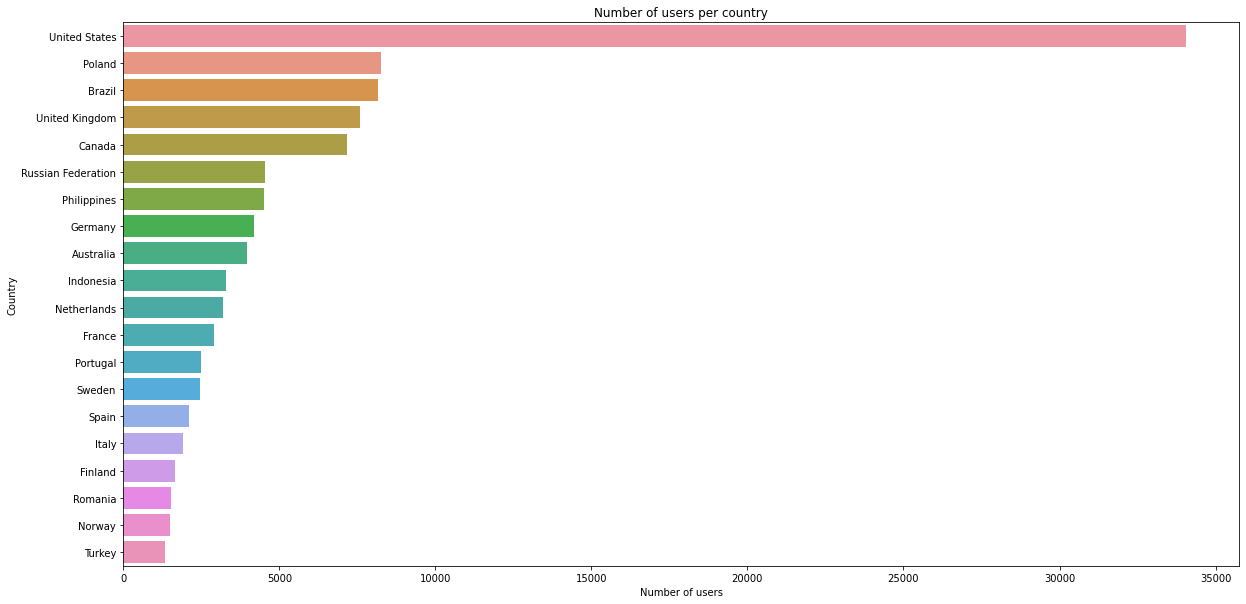

In [22]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
plot = sns.countplot(
    y="country", data=users, order=users["COUNTRY"].value_counts()[:20].index
)

title = "Number of users per country"
plt.title(title)
plt.xlabel("Number of users")
plt.ylabel("Country")
plt.show()
plot.get_figure().savefig(data / plot_path / (title + ".png"))

In [23]:
countryaff_counts = users.groupby("COUNTRYAFF").size().reset_index(name="counts")
# country_counts = country_counts.sort_values("counts", ascending=False)
countryaff_counts.to_csv(data / "countryaff_counts.csv", index=False)

count      178.000000
mean       752.308989
std       2883.548164
min          1.000000
25%          5.000000
50%         51.500000
75%        393.750000
max      34299.000000
Name: counts, dtype: float64


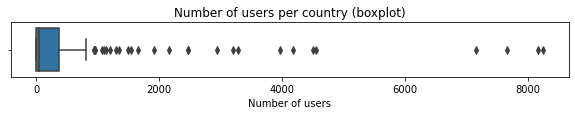

In [24]:
print(countryaff_counts["counts"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(
    x="counts",
    data=countryaff_counts[countryaff_counts["COUNTRYAFF"] != "United States"],
)
title = "Number of users per country (boxplot)"
plt.title(title)
plt.xlabel("Number of users")
plt.show()

TODO: derive a color scale from the distribution of number of users per country

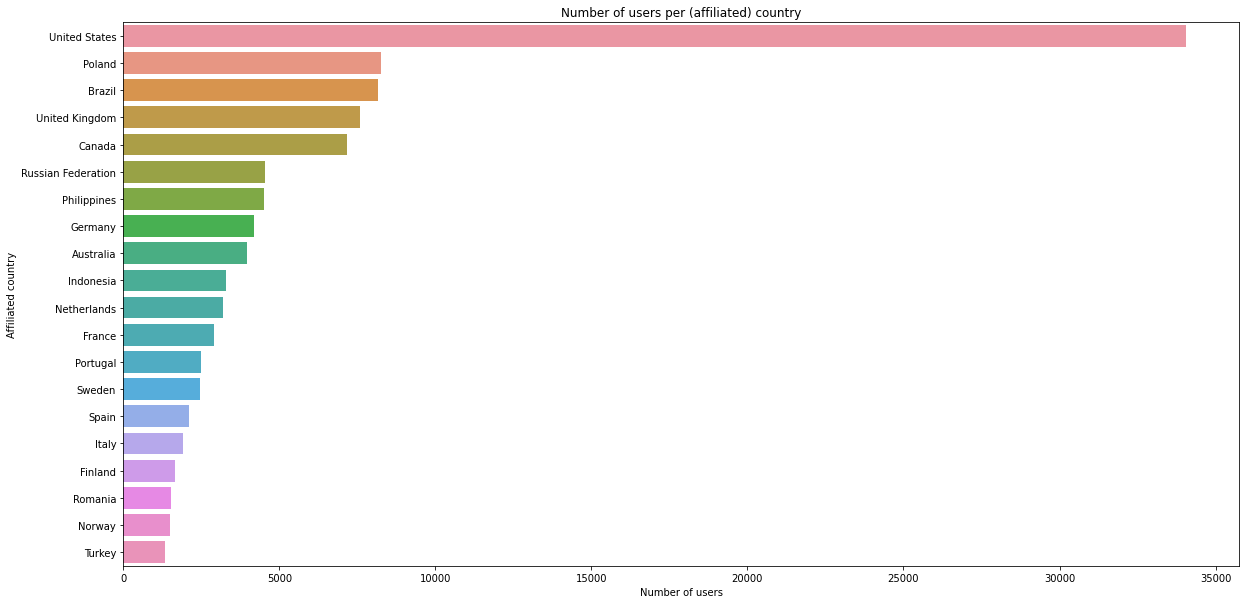

In [25]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
plot = sns.countplot(
    y="country", data=users, order=users["COUNTRYAFF"].value_counts()[:20].index
)

title = "Number of users per (affiliated) country"
plt.title(title)
plt.xlabel("Number of users")
plt.ylabel("Affiliated country")
plt.show()
plot.get_figure().savefig(data / plot_path / (title + ".png"))

## Countries of the users who watched the most animes

In [26]:
# group users by country and calculate the average "user_days_spent_watching"
users["user_days_spent_watching"] = users["user_days_spent_watching"].astype(float)
users.groupby("COUNTRY")["user_days_spent_watching"].mean().sort_values(ascending=False)

/tmp/ipykernel_16015/3480903769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users["user_days_spent_watching"] = users["user_days_spent_watching"].astype(float)


COUNTRY
Argentina                   2837.089936
Solomon Islands              224.930000
Burkina Faso                 213.437500
China                        179.864582
Mozambique                   169.985000
                               ...     
Togo                           8.010000
Anguilla                       4.550000
Marshall Islands               3.670000
Turks and Caicos Islands       0.000000
Senegal                        0.000000
Name: user_days_spent_watching, Length: 204, dtype: float64

Suspicious values: let's look at the cleaned dataset

## Users cleaned dataset

In [27]:
users_cleaned = pd.read_csv(data / "users_cleaned.csv")
users_cleaned["country"] = users_cleaned["location"].map(dict_ltc)

num_unique_users_cleaned = users_cleaned["user_id"].nunique()

# Users whose country is undefined (country is "" or is null)
num_undefined_cleaned = users_cleaned[
    users_cleaned["country"].isnull() | (users_cleaned["country"] == "")
]["user_id"].nunique()
print(
    "Number of users whose country is undefined: {:,} ({:.2f}%)".format(
        num_undefined_cleaned, 100 * num_undefined_cleaned / num_unique_users_cleaned
    )
)
users_cleaned = users_cleaned[
    users_cleaned["country"].notnull() & (users_cleaned["country"] != "")
]

print(
    "Number of users whose country is defined: {:,}".format(
        users_cleaned["user_id"].nunique()
    )
)

Number of users whose country is undefined: 12,575 (11.57%)
Number of users whose country is defined: 96,136


In [28]:
# for all the users who have a "country" column of the form "['', '']", remove the [] and ''. For instance, "['Finland', 'Sweden']" becomes "Finland, Sweden"
users_cleaned.loc[:, "country"] = (
    users_cleaned.loc[:, "country"]
    .str.replace(r"^\[\'", "")
    .str.replace(r"\'\]$", "")
    .str.replace(r"\'\,\s\'", ", ")
)
num_unique_users_cleaned = users_cleaned["user_id"].nunique()

# for the users who have a "country" column of the form "country1, country2, ..., countryn", duplicate the user n-1 times and assign the country1, country2, ..., countryn to the new users
users_cleaned_multiple_countries = users_cleaned[
    users_cleaned["country"].str.contains(",")
]
users_cleaned_multiple_countries.loc[
    :, "country"
] = users_cleaned_multiple_countries.loc[:, "country"].str.split(", ")
users_cleaned_multiple_countries = users_cleaned_multiple_countries.explode("country")

# merge the results with the original dataframe
users_cleaned = pd.concat(
    [
        users_cleaned[~users_cleaned["country"].str.contains(",")],
        users_cleaned_multiple_countries,
    ],
    axis=0,
)
assert users_cleaned["user_id"].nunique() == num_unique_users_cleaned

# for each user, add a column "COUNTRYAFF" based on "country" column and "COUNTRY" column of centroids
users_cleaned = users_cleaned.merge(
    centroids, left_on="country", right_on="COUNTRY", how="left"
)
users_cleaned

/tmp/ipykernel_16015/1396301318.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"^\[\'", "")
/tmp/ipykernel_16015/1396301318.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\'\]$", "")
/tmp/ipykernel_16015/1396301318.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\'\,\s\'", ", ")
/tmp/ipykernel_16015/1396301318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_cleaned_multiple_countries.loc[


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,...,stats_mean_score,stats_rewatched,stats_episodes,country,longitude,latitude,COUNTRY,ISO,COUNTRYAFF,AFF_ISO
0,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",...,6.15,6.0,4903,United States,-96.331617,38.820809,United States,US,United States,US
1,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",...,8.27,1.0,9701,Mexico,-101.553997,23.874361,Mexico,MX,Mexico,MX
2,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",...,9.70,6.0,697,Malaysia,114.633303,3.671661,Malaysia,MY,Malaysia,MY
3,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",...,7.86,0.0,1847,Netherlands,5.554136,52.134054,Netherlands,NL,Netherlands,NL
4,HimeAria,3129315,2,87,2,0,28,19.963194,Female,Poland,...,8.23,0.0,1314,Poland,19.435733,52.068481,Poland,PL,Poland,PL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96213,AdamNyandere,4539831,11,43,7,1,25,30.969444,Male,Singapore / Malaysia,...,9.07,60.0,1820,Singapore,103.810258,1.352825,Singapore,SG,Singapore,SG
96214,Roxas_the_key,242758,4,63,19,0,2,41.385417,Female,"Germany,Greece",...,8.63,0.0,2493,Germany,10.426171,51.083045,Germany,DE,Germany,DE
96215,Roxas_the_key,242758,4,63,19,0,2,41.385417,Female,"Germany,Greece",...,8.63,0.0,2493,Greece,23.110369,39.420123,Greece,GR,Greece,GR
96216,Tachibana-chan,5078714,17,105,2,4,37,24.311806,Female,India/Saudi Arabia,...,7.32,0.0,1530,India,81.173004,23.586301,India,IN,India,IN


In [29]:
# rows whose countries who were not mapped
temp = users_cleaned[users_cleaned["COUNTRYAFF"].isnull()]["country"]
print(len(temp))
print(*temp.sort_values().unique(), sep="\n")

198
ambiguous


In [30]:
# group users by country and calculate the average "user_days_spent_watching"
users_cleaned["user_days_spent_watching"] = users_cleaned[
    "user_days_spent_watching"
].astype(float)

df_days_spent_watching = (
    users_cleaned.groupby("COUNTRY")
    .agg({"user_id": "nunique", "user_days_spent_watching": "mean"})
    .sort_values(by="user_days_spent_watching", ascending=False)
)
df_days_spent_watching.columns = ["num_users", "num_days_spent_watching_mean"]
df_days_spent_watching

,num_users,num_days_spent_watching_mean
COUNTRY,,
Réunion,3,219.394823
Solomon Islands,1,216.353472
Cameroon,1,186.013426
Chad,1,182.938889
New Caledonia,1,176.944444
...,...,...
Ghana,2,9.103472
Papua New Guinea,3,8.046065
Togo,1,8.018750


We observe that:
- Argentina is no longer top 1
- A lot of countries have seen their mean decrease
- The countries with mean 0 have been removed 

Let us look only at the number of users per country for this cleaned dataset

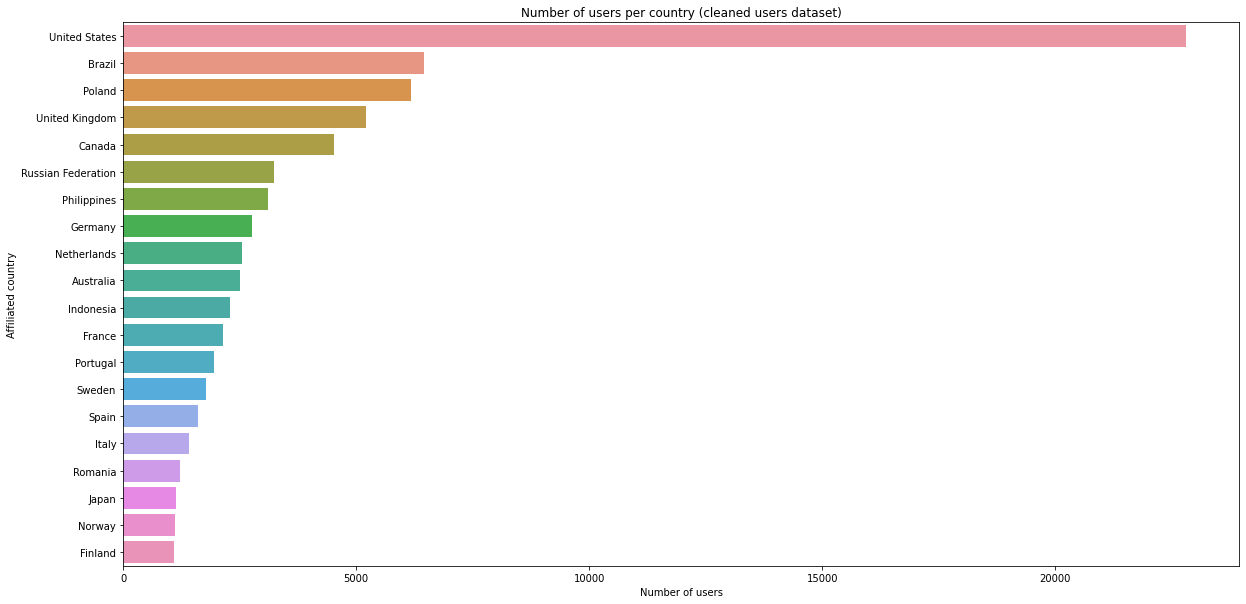

In [31]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
plot = sns.countplot(
    y="country",
    data=users_cleaned,
    order=users_cleaned["COUNTRY"].value_counts()[:20].index,
)

title = "Number of users per country (cleaned users dataset)"
plt.title(title)
plt.xlabel("Number of users")
plt.ylabel("Affiliated country")
plt.show()
plot.get_figure().savefig(data / plot_path / (title + ".png"))

- Brazil <-> Poland
- Australia, Indonesia, Netherlands -> Netherlands, Australia, Indonesia

count    194.000000
mean      66.651704
std       33.266969
min        0.977083
25%       52.235000
50%       63.326514
75%       74.154728
max      219.394823
Name: num_days_spent_watching_mean, dtype: float64


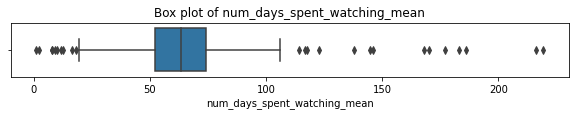

In [32]:
print(df_days_spent_watching["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=df_days_spent_watching)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

Hmm, lots of outliers, even in the cleaned version. Let's look at the corresponding countries

In [33]:
df_days_spent_watching.sort_values(by="num_days_spent_watching_mean", ascending=False)[
    :20
]

,num_users,num_days_spent_watching_mean
COUNTRY,,
Réunion,3,219.394823
Solomon Islands,1,216.353472
Cameroon,1,186.013426
Chad,1,182.938889
New Caledonia,1,176.944444
Kyrgyzstan,1,170.054861
Pitcairn,1,168.003472
US Virgin Islands,2,146.014931
Mozambique,2,144.828235


We observe that the countries with very few users dominate the top.
Let us look only at the countries which count many users (say, more than 1000), to have more representative samples

In [34]:
df_days_spent_watching_100 = df_days_spent_watching[
    df_days_spent_watching["num_users"] >= 100
]
df_days_spent_watching_100.sort_values(
    by="num_days_spent_watching_mean", ascending=False
)[:20]

,num_users,num_days_spent_watching_mean
COUNTRY,,
Morocco,111,85.877816
Slovenia,107,83.211293
France,2137,81.467389
Saudi Arabia,570,78.820426
Germany,2765,77.432438
Spain,1602,75.900733
Portugal,1959,75.745659
Chile,489,75.500148
Italy,1421,75.095714


count    65.000000
mean     65.492298
std       8.924844
min      45.187619
25%      61.444956
50%      66.267525
75%      72.263612
max      85.877816
Name: num_days_spent_watching_mean, dtype: float64


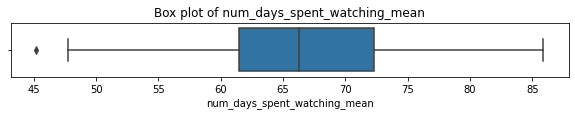

In [35]:
print(df_days_spent_watching_100["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=df_days_spent_watching_100)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

We observe that the distribution is between 60 and 70 hours. Do people watch the same animes around the world?

Country affiliation: United Kingdom, France, Spain, Netherlands, etc.

In [36]:
df_days_spent_watching_aff = (
    users_cleaned.groupby("COUNTRYAFF")
    .agg({"user_id": "nunique", "user_days_spent_watching": "mean"})
    .sort_values(by="user_days_spent_watching", ascending=False)
)
df_days_spent_watching_aff.columns = ["num_users", "num_days_spent_watching_mean"]
df_days_spent_watching.sort_values(by="num_days_spent_watching_mean", ascending=False)[
    :20
]

,num_users,num_days_spent_watching_mean
COUNTRY,,
Réunion,3,219.394823
Solomon Islands,1,216.353472
Cameroon,1,186.013426
Chad,1,182.938889
New Caledonia,1,176.944444
Kyrgyzstan,1,170.054861
Pitcairn,1,168.003472
US Virgin Islands,2,146.014931
Mozambique,2,144.828235


Let us look again only at the countries which have more than 100 users

In [37]:
df_days_spent_watching_aff_100 = df_days_spent_watching_aff[
    df_days_spent_watching_aff["num_users"] >= 100
]
df_days_spent_watching_aff_100.sort_values(
    by="num_days_spent_watching_mean", ascending=False
)[:20]

,num_users,num_days_spent_watching_mean
COUNTRYAFF,,
Morocco,111,85.877816
Slovenia,107,83.211293
France,2147,81.733735
Saudi Arabia,570,78.820426
Germany,2765,77.432438
Spain,1638,76.024048
Portugal,1959,75.745659
Chile,489,75.500148
Italy,1421,75.095714


France increases, Spain decreases